In [2]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit

# Import from BB analysis github
import HopFinder
import HOP
import LC
import LC_Set

# COSI Analysis

In [100]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [307]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400

        integral = np.sum(temp_sum)
        flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral]))
    return flarestack


In [324]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='MJD')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)

        COSI_BAND = np.array([flarenames, flareintegrals]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_df=pd.DataFrame(COSI_BAND_ALL)

COSI_BAND_ALL_df


0
8.43e-07 8.06e-09 8.3494e-07 8.3494e-08 9.1554e-08
<class 'list'>
 
[['0' '0']
 ['4FGL J0538.8-4405' '0.0005451697999999999']
 ['4FGL J0538.8-4405' '1.2924799999999999e-05']
 ['4FGL J0538.8-4405' '3.48061e-05']
 ['4FGL J0538.8-4405' '5.054e-06']
 ['4FGL J0538.8-4405' '3.90418e-05']
 ['4FGL J0538.8-4405' '0.0001282078']
 ['4FGL J0538.8-4405' '5.4502e-06']
 ['4FGL J0538.8-4405' '5.532800000000001e-06']
 ['4FGL J0538.8-4405' '0.00012405400000000002']]
aaaaaaa
[0.         1.02134786 0.02421395 0.06520746 0.00946841 0.07314282
 0.24019079 0.01021067 0.01036542 0.23240885]
bbbbbbbbbbbbb
['0' '4FGL J0538.8-4405' '4FGL J0538.8-4405' '4FGL J0538.8-4405'
 '4FGL J0538.8-4405' '4FGL J0538.8-4405' '4FGL J0538.8-4405'
 '4FGL J0538.8-4405' '4FGL J0538.8-4405' '4FGL J0538.8-4405']
[['0' '0.0']
 ['4FGL J0538.8-4405' '1.0213478633503774']
 ['4FGL J0538.8-4405' '0.024213954742597556']
 ['4FGL J0538.8-4405' '0.0652074562210885']
 ['4FGL J0538.8-4405' '0.009468411679026992']
 ['4FGL J0538.8-4405' '0.0731

,0,1
0,0,0
1,0,0.0
2,4FGL J0538.8-4405,1.0213478633503774
3,4FGL J0538.8-4405,0.024213954742597556
4,4FGL J0538.8-4405,0.0652074562210885
...,...,...
612,4FGL J0428.6-3756,0.0021125008540238237
613,4FGL J0428.6-3756,0.01783332074869518
614,4FGL J0428.6-3756,0.019806691229046523
615,4FGL J0428.6-3756,0.00981713039936228


In [328]:
COSI_BAND_ALL_df[COSI_BAND_ALL_df!=0]

,0,1
0,0,0
1,0,0.0
2,4FGL J0538.8-4405,1.0213478633503774
3,4FGL J0538.8-4405,0.024213954742597556
4,4FGL J0538.8-4405,0.0652074562210885
...,...,...
612,4FGL J0428.6-3756,0.0021125008540238237
613,4FGL J0428.6-3756,0.01783332074869518
614,4FGL J0428.6-3756,0.019806691229046523
615,4FGL J0428.6-3756,0.00981713039936228


In [ ]:
i=1
table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
COSI_BAND = []
flare_array = []

Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]
sourcename = COSI_LAT_Sources['Name'][i]
factor = COSI_LAT_Sources['ph/s_ratio'][i]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2']
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

hops_bl = sourcelightcurve.hops
plt.close('all')
fluence_integrator(sourcelightcurve,time='MJD')

COSI_BAND.append([titlestring,np.array(flare_array)*factor*Aeff])



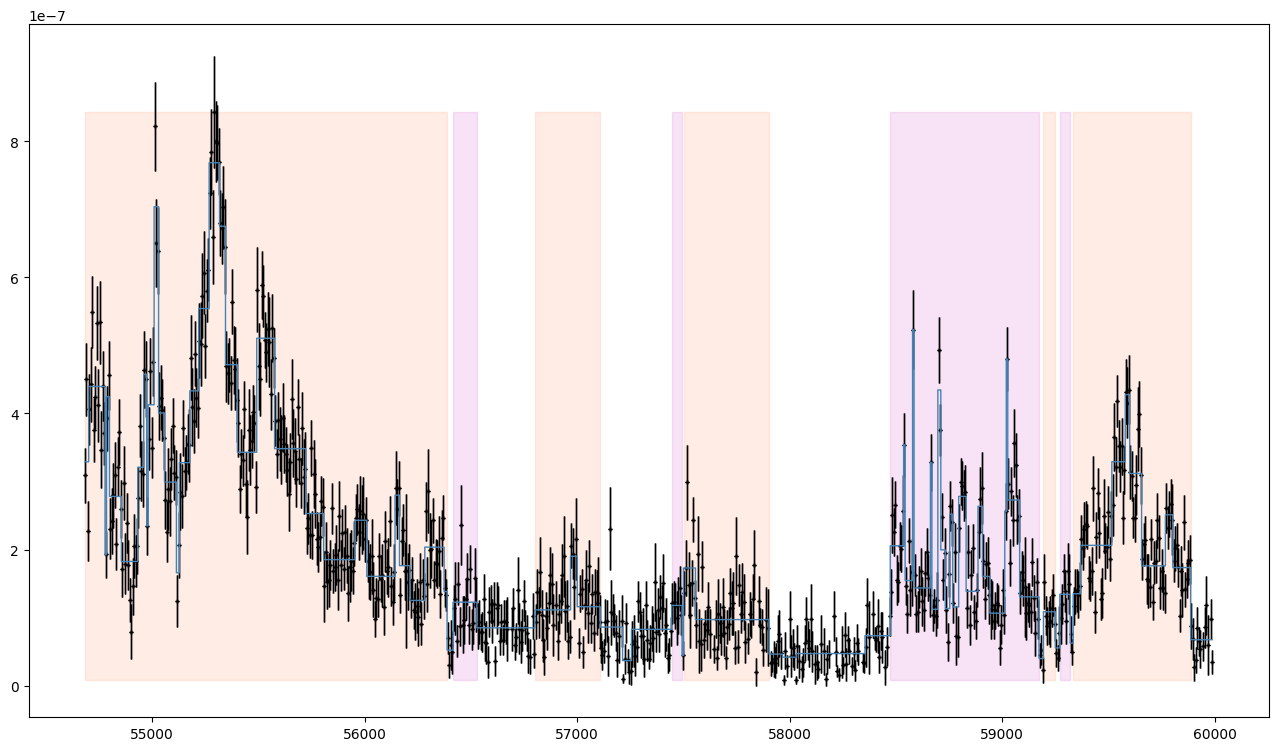

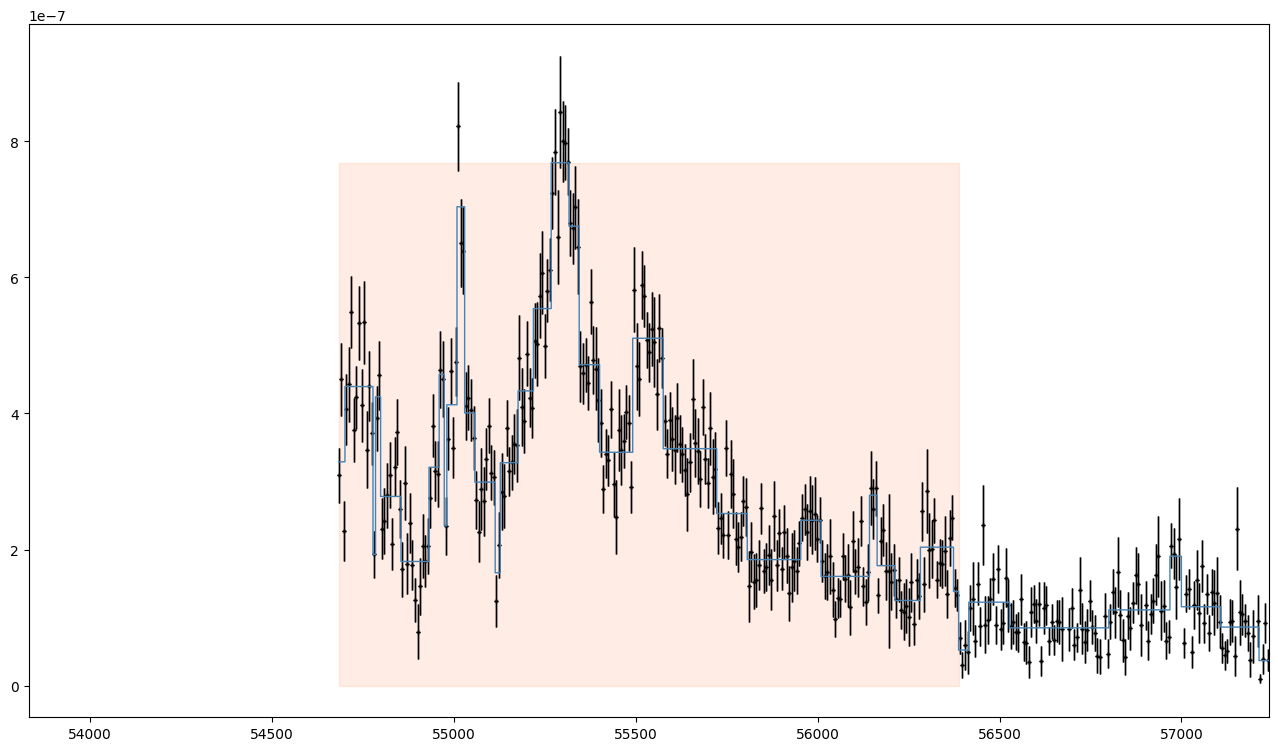

In [221]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [222]:
fluence_integrator(sourcelightcurve,time='s')

[47.10267071999999,
 1.11670272,
 3.0072470399999998,
 0.43666560000000004,
 3.373211520000001,
 11.077153920000002,
 0.4708972800000001,
 0.4780339199999999,
 10.718265599999999]

In [223]:
sourcelightcurve.name

'4FGL J0538.8-4405'

In [199]:
flare_array = sourcelightcurve.flux[np.min(hops_bl[0].iis):np.max(hops_bl[0].iis)]
sourcelightcurve.time[np.min(hops_bl[0].iis):np.max(hops_bl[0].iis)][1]-sourcelightcurve.time[np.min(hops_bl[0].iis):np.max(hops_bl[0].iis)][0]


7.0

In [200]:
def fluence_integrator(sourcelightcurve, time = 'MJD'):
    flare_array = []
    hops_bl = sourcelightcurve.hops
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp = temp * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp = temp * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp = temp * 86400
        
        flare_array.append(temp)
    return flare_array


In [185]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3. 11.  1.  2.  8. 11.  4.  2.  1.  4.  3.  4.  8.  2.  7.  6.  7.  7.
  4.  8. 13. 12. 21. 12. 21.  8. 19.  3.  7. 10. 13.  2.  4. 16. 36. 23.
  4. 15. 14.  6. 27.  7.  1.  8. 44.  8.  8. 35. 13.  9.  1.  5.  1. 11.
  1.  4.  2.  3.  3.  2.  4.  5.  8.  3.  5. 10.  1.  1.  8. 13.  3.  8.
  3.  7.  2.  5. 21.  9.  3.  8. 16.  5. 12. 13.]


1

In [158]:

basetime = sourcelightcurve.time[np.min(hops_bl[0].iis):np.max(hops_bl[0].iis)]
basetime

array([54690.00001157, 54697.00001157, 54704.00001157, 54711.00001157,
       54718.00001157, 54725.00001157, 54732.00001157, 54739.00001157,
       54746.00001157, 54753.00001157, 54760.00001157, 54767.00001157,
       54774.00001157, 54781.00001157, 54788.00001157, 54795.00001157,
       54802.00001157, 54809.00001157, 54816.00001157, 54823.00001157,
       54830.00001157, 54837.00001157, 54844.00001157, 54851.00001157,
       54858.00001157, 54865.00001157, 54872.00001157, 54879.00001157,
       54886.00001157, 54893.00001157, 54900.00001157, 54907.00001157,
       54914.00001157, 54921.00001157, 54928.00001157, 54935.00001157,
       54942.00001157, 54949.00001157, 54956.00001157, 54963.00001157,
       54970.00001157, 54977.00001157, 54984.00001157, 54991.00001157,
       54998.00001157, 55005.00001157, 55012.00001157, 55019.00001157,
       55026.00001157, 55033.00001157, 55040.00001157, 55047.00001157,
       55054.00001157, 55061.00001157, 55068.00001157, 55075.00001157,
      

In [156]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54686.50001157, 54693.50001157, 54700.50001157, 54707.50001157,
       54714.50001157, 54721.50001157, 54728.50001157, 54735.50001157,
       54742.50001157, 54749.50001157, 54756.50001157, 54763.50001157,
       54770.50001157, 54777.50001157, 54784.50001157, 54791.50001157,
       54798.50001157, 54805.50001157, 54812.50001157, 54819.50001157,
       54826.50001157, 54833.50001157, 54840.50001157, 54847.50001157,
       54854.50001157, 54861.50001157, 54868.50001157, 54875.50001157,
       54882.50001157, 54889.50001157, 54896.50001157, 54903.50001157,
       54910.50001157, 54917.50001157, 54924.50001157, 54931.50001157,
       54938.50001157, 54945.50001157, 54952.50001157, 54959.50001157,
       54966.50001157, 54973.50001157, 54980.50001157, 54987.50001157,
       54994.50001157, 55001.50001157, 55008.50001157, 55015.50001157,
       55022.50001157, 55029.50001157, 55036.50001157, 55043.50001157,
       55050.50001157, 55057.50001157, 55064.50001157, 55071.50001157,
      

In [166]:
sourcelightcurve.time[sourcelightcurve.time==hops_bl[0].start_time]

array([54683.00001157])

In [173]:
np.where(sourcelightcurve.time==hops_bl[0].end_time)

(array([], dtype=int64),)

In [174]:
hops_bl[0].end_time

56387.50001157408

In [177]:
sourcelightcurve.block_pbin

array([3.29000000e-07, 3.29000000e-07, 3.29000000e-07, 4.39545455e-07,
       4.39545455e-07, 4.39545455e-07, 4.39545455e-07, 4.39545455e-07,
       4.39545455e-07, 4.39545455e-07, 4.39545455e-07, 4.39545455e-07,
       4.39545455e-07, 4.39545455e-07, 1.93000000e-07, 4.24500000e-07,
       4.24500000e-07, 2.78125000e-07, 2.78125000e-07, 2.78125000e-07,
       2.78125000e-07, 2.78125000e-07, 2.78125000e-07, 2.78125000e-07,
       2.78125000e-07, 1.82590909e-07, 1.82590909e-07, 1.82590909e-07,
       1.82590909e-07, 1.82590909e-07, 1.82590909e-07, 1.82590909e-07,
       1.82590909e-07, 1.82590909e-07, 1.82590909e-07, 1.82590909e-07,
       3.21000000e-07, 3.21000000e-07, 3.21000000e-07, 3.21000000e-07,
       4.57500000e-07, 4.57500000e-07, 2.35000000e-07, 4.12750000e-07,
       4.12750000e-07, 4.12750000e-07, 4.12750000e-07, 7.03666667e-07,
       7.03666667e-07, 7.03666667e-07, 4.00750000e-07, 4.00750000e-07,
       4.00750000e-07, 4.00750000e-07, 2.99125000e-07, 2.99125000e-07,
      